# Team as an entity model

This model is a

In [1]:
# Import
from torch import nn
from torch.utils.data import DataLoader

from models.models import *
from datasets.datasets import *
from utils import *

c:\Users\thgla\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Device: {device}")

Device: cuda


# Dataset

In [23]:
dataset = get_player_dataset(NL=[5])
dataset_team = get_team_dataset(NL=[5])

reading file
Loaded 13794 rows.
Normalizing features
['GP', 'G', 'A', 'PTS', 'PS', 'EV', 'PP', 'S']
Loading player data
creating dataset structure
creating player dict
Targets
['W%', 'L%', 'S']
Normalizing features
[]
All features
['W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SV%']
Loading player data
creating dataset structure


In [3]:
dataset_combined = get_combined_dataset(NL=[5])

reading file
Loaded 13794 rows.
Normalizing features
['GP', 'G', 'A', 'PTS', 'PS', 'EV', 'PP', 'S']
Loading player data
creating dataset structure
creating player dict
Targets
['W%', 'L%', 'S']
Normalizing features
[]
All features
['W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SV%']
Loading player data
creating dataset structure


In [9]:
N_datasets_combined = dataset_combined.random_split(0.1)
dataset_train_combined = CombinedDataset(N_datasets_combined[0][1],max_N=5)

# Dataloader

In [14]:
batch_size = 100

N_datasets = dataset.random_split(0.1)

#concatenate all datasets together

all_datasets_train = []
for i in range(len(N_datasets)):
    all_datasets_train += N_datasets[i][1]
all_datasets_test = []
for i in range(len(N_datasets)):
    all_datasets_test += N_datasets[i][2]

dataset_train = PlayerDataset(all_datasets_train, max_N=5)
dataset_test = PlayerDataset(all_datasets_test, max_N=5)

print(f"Train size: {len(dataset_train)}")
print(f"Test size: {len(dataset_test)}")

# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

Train size: 3212
Test size: 378
(tensor([[-0.1698, -0.7990, -0.2150, -0.3548,  0.5797, -0.7037, -0.7603, -0.6131],
        [ 0.2892, -0.7990,  0.0209, -0.1664, -0.2918, -0.7037, -0.7603,  0.0984],
        [-0.5582, -0.1871, -1.1158, -0.6070, -0.5585, -0.0260, -0.7603, -0.3488],
        [ 0.7835, -1.4110,  0.5892,  0.2648,  0.6479, -1.3815, -0.7603,  0.4655],
        [-0.6994, -0.7990, -0.7833, -0.7742, -0.5585, -1.3815,  0.0700, -0.3488]]), tensor([ 0.3598, -0.7990,  0.5363,  0.2648,  1.1038, -1.3815,  0.0700,  0.2041]))


Text(0.5, 1.0, 'Mutual Information between Stats')

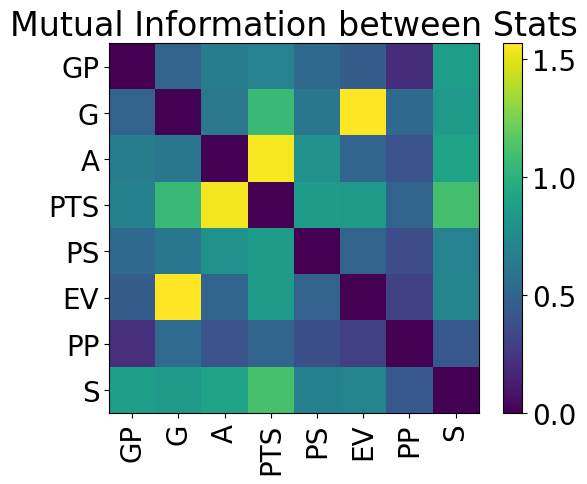

In [12]:
from sklearn.feature_selection import mutual_info_regression
#look at mutual information between stats from current season to N seasons ago

mutual_info = np.zeros((8,8))
raw_data = dataset.all_data_normalized.drop(columns=['Rk', 'Age', '+/-','Player', 'Season','Tm', 'PIM', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).values
for j in range(len(raw_data[0])):
    mi = mutual_info_regression(raw_data,raw_data[:,j])
    mutual_info[j] = mi

#remove diagonal
np.fill_diagonal(mutual_info,0)

plt.imshow(mutual_info)
#larger font
plt.rc('font', size=20)
plt.colorbar()

plt.xticks(np.arange(8),dataset.all_data_normalized.drop(columns=['Rk', 'Age', '+/-','Player', 'Season','Tm', 'PIM', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).columns,rotation=90,fontsize=20)
plt.yticks(np.arange(8),dataset.all_data_normalized.drop(columns=['Rk', 'Age', '+/-','Player', 'Season','Tm', 'PIM', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).columns,fontsize=20)
plt.title('Mutual Information between Stats')

Index(['team name', 'W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S', 'S%',
       'SV%', 'Season'],
      dtype='object')


([<matplotlib.axis.YTick at 0x172e23cd760>,
 [Text(0, 0, 'W%'),
  Text(0, 1, 'L%'),
  Text(0, 2, 'GF/G'),
  Text(0, 3, 'GA/G'),
  Text(0, 4, 'PIM/G'),
  Text(0, 5, 'S'),
  Text(0, 6, 'S%'),
  Text(0, 7, 'SV%')])

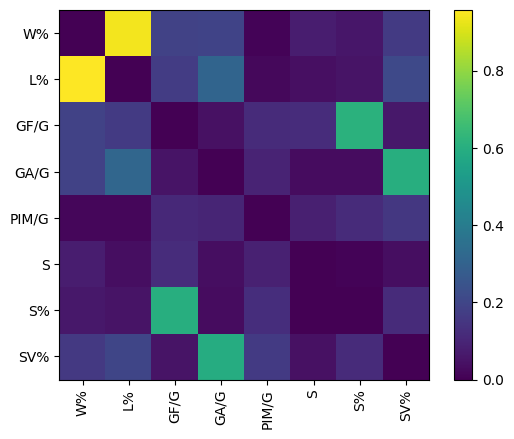

In [10]:
#mutual info with team stats
print(dataset_team.all_data_normalized.columns)
raw_data_team = dataset_team.all_data_normalized.drop(columns=['team name', 'oPIM/G', 'Season'],axis=1).values

mutual_info_team = np.zeros((8,8))
for j in range(len(raw_data[0])):
    mi = mutual_info_regression(raw_data_team,raw_data_team[:,j])
    mutual_info_team[j] = mi

#remove diagonal
np.fill_diagonal(mutual_info_team,0)

plt.imshow(mutual_info_team)
plt.colorbar()
plt.xticks(np.arange(8),dataset_team.all_data_normalized.drop(columns=['team name', 'oPIM/G', 'Season'],axis=1).columns,rotation=90)
plt.yticks(np.arange(8),dataset_team.all_data_normalized.drop(columns=['team name', 'oPIM/G', 'Season'],axis=1).columns)

torch.Size([1938, 17])


Text(0.5, 1.0, 'Mutual Information between Team and Player Stats')

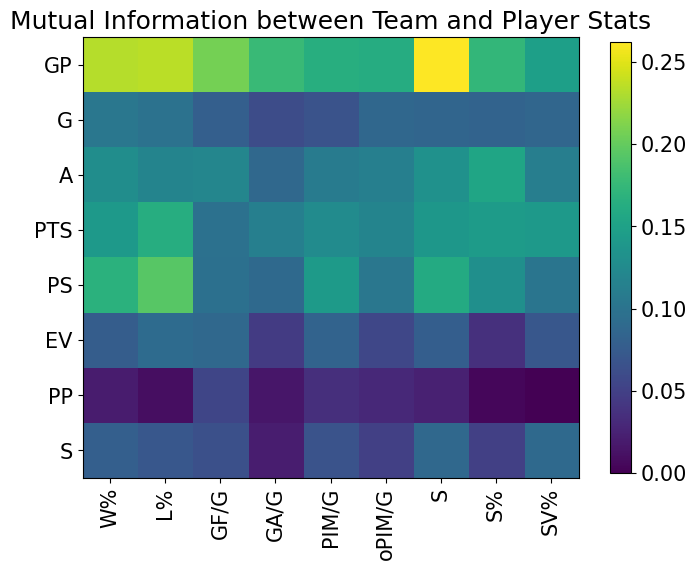

In [29]:
from sklearn.feature_selection import mutual_info_regression
stacked_data_combined = torch.stack([dataset_train_combined.data[i][0][0] for i in range(len(dataset_train_combined))])

print(stacked_data_combined.shape)

mutual_info_team = np.zeros((8,9))
for j in range(8):
    mi = mutual_info_regression(stacked_data_combined,stacked_data_combined[:,j])
    mutual_info_team[j] = mi[8:]


plt.figure(figsize=(8,8))
plt.imshow(mutual_info_team)
plt.rc('font', size=15)
plt.colorbar(shrink=0.7)
plt.xticks(np.arange(9),['W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SV%'],rotation=90)
plt.yticks(np.arange(8),['GP', 'G', 'A', 'PTS', 'PS', 'EV', 'PP','S'])
                        

plt.title('Mutual Information between Team and Player Stats')


torch.Size([3212, 5, 8])


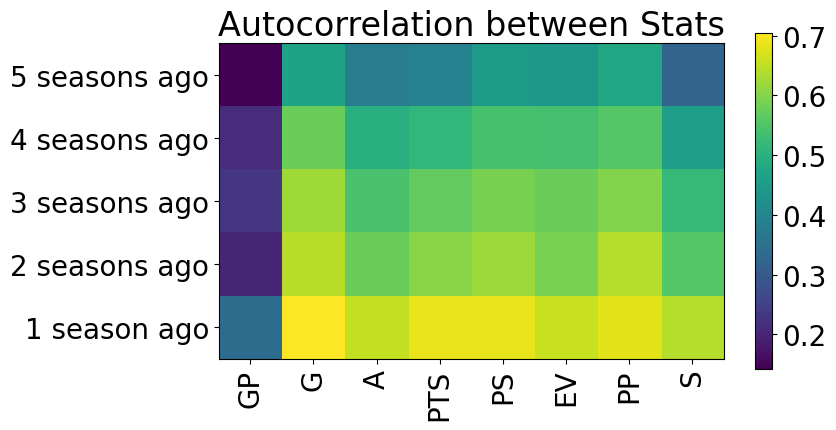

In [23]:
#measure autocorrelation

stacked_data = torch.stack([dataset_train.data[i][0] for i in range(len(dataset_train))])
stacked_data_target = torch.stack([dataset_train.data[i][1] for i in range(len(dataset_train))])
print(stacked_data.shape)

autocorr = np.zeros((5,8))
for i in range(5):
    for j in range(8):
        autocorr[i,j] = np.corrcoef(stacked_data[:,i,j],stacked_data_target[:,j])[0,1]

plt.figure(figsize=(9,9))
plt.imshow(autocorr)
#larger font
plt.rc('font', size=20)
plt.title('Autocorrelation between Stats')
#make smaller colorbar by using the shrink argument
plt.colorbar(shrink=0.4)


plt.xticks(np.arange(8),dataset.all_data_normalized.drop(columns=['Rk', 'Age', '+/-','Player', 'Season','Tm', 'PIM', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).columns,rotation=90,fontsize=20)
plt.yticks(np.arange(5),['5 seasons ago','4 seasons ago','3 seasons ago','2 seasons ago','1 season ago'],fontsize=20)
plt.tight_layout()
            
    


# Training and Validation

In [155]:
# NOTE: N will be variable, as the input size
input_size = len(dataset_train.__getitem__(0)[0][0])
print(f"Input size: {input_size}")
hidden_size = 48
MLP_hidden_size = 96
num_layers = 1



Input size: 8


In [156]:
model = PlayerStandalone(input_size=input_size, hidden_size=hidden_size, MLP_hidden_size=MLP_hidden_size, num_layers=num_layers, device=device).to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 10
loss_interval = 1

In [157]:
(model, train_losses, val_losses) = train_and_validate(model, criterion, optimizer, dataloader_train, dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)

0 th epoch :  0.6752637081949162
Validation loss for epoch 0: 0.6385094715016228
Validation loss for epoch 1: 0.6264926727328982
2 th epoch :  0.6275380933817309
Validation loss for epoch 2: 0.62684337581907
Validation loss for epoch 3: 0.6242884333644595
4 th epoch :  0.6239564504820047
Validation loss for epoch 4: 0.6251411608287266
Validation loss for epoch 5: 0.6242515636341912
6 th epoch :  0.6215088672654325
Validation loss for epoch 6: 0.6263829597405025
Validation loss for epoch 7: 0.6243920411382403
8 th epoch :  0.6201702743461451
Validation loss for epoch 8: 0.6241860964468547


KeyboardInterrupt: 

In [111]:
model_linear = PlayerLinear(input_size=input_size, N=5, device=device).to(device)
criterion_linear = RMSELoss()
optimizer_linear = torch.optim.Adam(model_linear.parameters(),lr=0.001)
epochs_linear = 40
loss_interval_linear = 5

In [112]:
(model_linear, train_losses_linear, val_losses_linear) = train_and_validate(model_linear, criterion_linear, optimizer_linear, dataloader_train, dataloader_test, epochs=epochs_linear, loss_interval=loss_interval_linear, device=device)

0 th epoch :  0.9049331889008031
Validation loss for epoch 0: 0.7096779942512512
Validation loss for epoch 5: 0.6027715057134628
10 th epoch :  0.6072598533196882
Validation loss for epoch 10: 0.5960074812173843
Validation loss for epoch 15: 0.5749162435531616
20 th epoch :  0.5962518977396416
Validation loss for epoch 20: 0.591045007109642
Validation loss for epoch 25: 0.5755247473716736
30 th epoch :  0.5926780474908424
Validation loss for epoch 30: 0.5681677013635635
Validation loss for epoch 35: 0.5782352685928345


In [136]:
#average results
avg_predictions = []
avg_targets = []
for step, (x,y) in enumerate(dataset_train):
    #drop all padded zeros
    x = x[x.sum(dim=1) != 0]
    avg_predictions.append(torch.mean(x, dim=0)) 
    avg_targets.append(y)

avg_predictions = torch.stack(avg_predictions)
avg_targets = torch.stack(avg_targets)
avg_loss = criterion(avg_predictions, avg_targets)

# Plot Results

Average loss: 0.7126381397247314


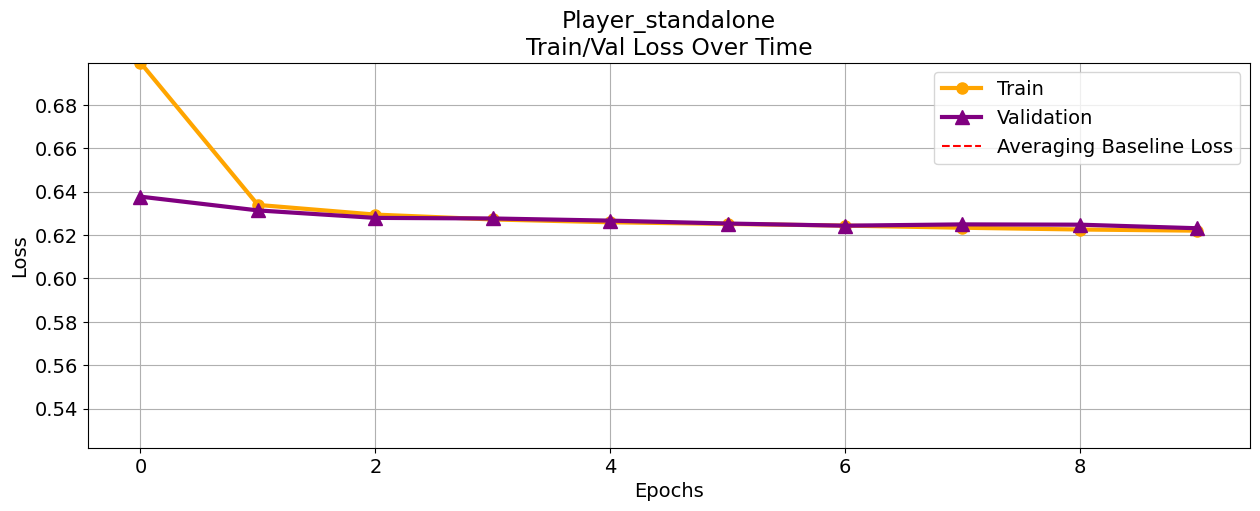

In [151]:
print(f"Average loss: {avg_loss}")
plot_train_v_loss("Player_standalone",train_losses, val_losses, loss_interval, baseline_loss=avg_loss)


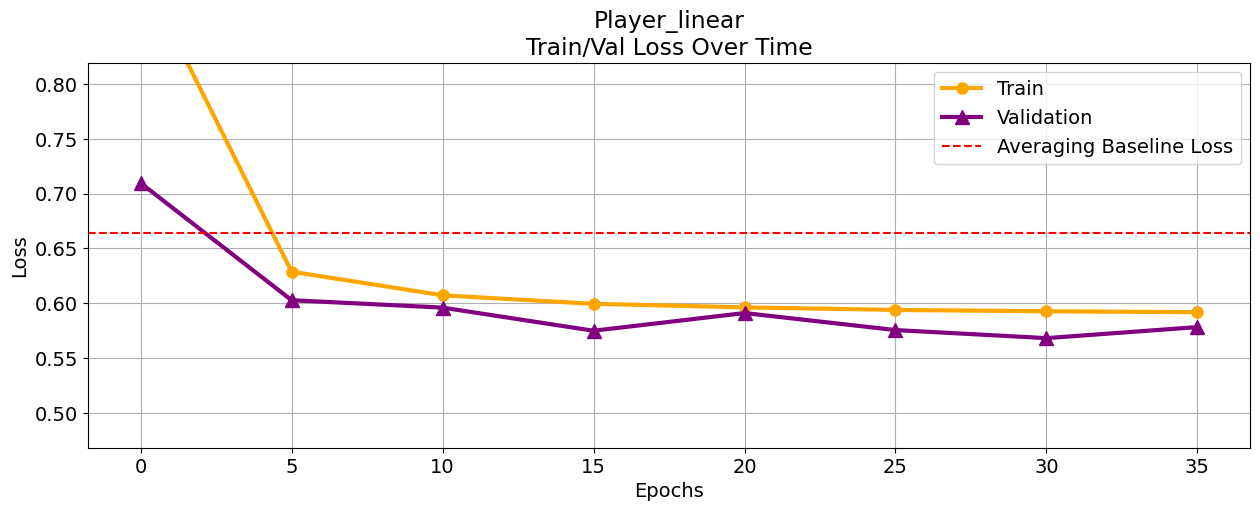

In [115]:
plot_train_v_loss("Player_linear",train_losses_linear, val_losses_linear, loss_interval, baseline_loss=avg_loss)

In [116]:
# Define loss
def Ind_RMSELoss(yhat, y):
    return torch.sqrt(torch.mean((yhat-y)**2,axis=0))

In [117]:
avg_loss_ind = Ind_RMSELoss(avg_predictions, avg_targets)
print(f"Average loss individual: {avg_loss_ind}")

sample =dataset_train.__getitem__(0)
print(sample[1])
print(dataset.unnormalize(sample[1]))


pred_sample = model(sample[0].unsqueeze(0).to(device))
print(dataset.unnormalize(pred_sample.cpu().detach()))

pred_sample_linear = model_linear(sample[0].unsqueeze(0).to(device))
print(dataset.unnormalize(pred_sample_linear.cpu().detach()))

Average loss individual: tensor([0.7399, 0.6320, 0.6093, 0.5829, 0.7378, 0.6639, 0.7719, 0.5420])
tensor([-0.1345, -0.4411, -0.3645, -0.3548,  0.0365, -0.7037, -0.7603, -0.1584])
tensor([44.0000,  2.0000,  4.0000,  6.0000,  1.9000,  1.0000,  0.0000, 32.0000])
tensor([[62.9642,  1.7425,  8.5793, 12.4374,  2.7494,  1.4527,  0.1728, 55.8191]])
tensor([[58.5362,  1.7094,  8.0973,  8.7693,  2.7860,  1.2783,  0.1737, 38.3846]])


# Exploration results

Exploration 

In [118]:
test_preds = []
test_targets = []
test_avg_baseline = []
test_avg_baseline_linear = []



for step, (x,y) in enumerate(dataset_test): 
    pred = model(x.unsqueeze(0).to(device))[0]
    test_preds.append(pred.cpu().detach())
    test_targets.append(y)
    pred_linear = model_linear(x.unsqueeze(0).to(device))[0]
    test_avg_baseline_linear.append(pred_linear.cpu().detach())
    #drop all padded zeros
    x = x[x.sum(dim=1) != 0]
    test_avg_baseline.append(torch.mean(x, dim=0))

    
    
#stack all the tensors
test_preds = torch.stack(test_preds)
test_targets = torch.stack(test_targets)
test_avg_baseline = torch.stack(test_avg_baseline)
test_avg_baseline_linear = torch.stack(test_avg_baseline_linear)


    
preds_n_targets = (test_targets, test_preds, test_avg_baseline, test_avg_baseline_linear)

#unnormalize
preds_n_targets = (dataset.unnormalize(preds_n_targets[0]), dataset.unnormalize(preds_n_targets[1]), dataset.unnormalize(preds_n_targets[2]), dataset.unnormalize(preds_n_targets[3]))


In [119]:
print(preds_n_targets[3].shape)

torch.Size([332, 8])


In [120]:
def plot_correlation(pred_n_targets_dict, criterion, stat_names):
    """
    Plots the divergence between the predictions and the targets. It includes the max positive and negative deviations.

    NL: list of the N values used for targets/preds
    pred_n_targets_dict: dictionary where each entry is an N from NL and contains the list of all target/prediction pairs
    criterion: loss function object

    NOTE: NL, targets and preds must all have the same size
    """

    
    y, y_hat, y_base, y_base_avg = pred_n_targets_dict

    for stat_idx in range(len(y[0])):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        fig.suptitle(f'Predictions for stat: {stat_names[stat_idx]}', fontsize=18)

        #add axis labels
        ax1.set_xlabel("Target")
        ax1.set_ylabel("Prediction")
        ax2.set_xlabel("Target")
        ax2.set_ylabel("Prediction")

        target_stats = y[:, stat_idx]
        preds_stats = y_hat[:, stat_idx]
        baseline_stats = y_base_avg[:, stat_idx]
        
        
        ax1.scatter(target_stats, preds_stats, c="b",s=10)
        ax1.plot(target_stats,target_stats)

       

        # Basline linear
        ax2.scatter(target_stats, baseline_stats, c="b",s=10)
        ax2.plot(target_stats,target_stats)
        
        #annotate with the loss
        loss_per_feature = criterion(preds_stats, target_stats)
        loss_per_feature_base = criterion(baseline_stats, target_stats)
        ax1.annotate(f"Loss: {round(loss_per_feature.item(),4)}", xy=(0.5, 0.1), xycoords='axes fraction')
        ax2.annotate(f"Loss: {round(loss_per_feature_base.item(),4)}", xy=(0.5, 0.1), xycoords='axes fraction')

        
        ax1.grid()
        ax2.grid()
        
        plt.show()

<BarContainer object of 8 artists>

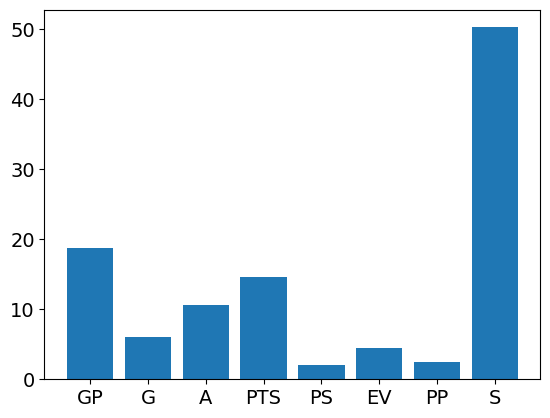

In [121]:
#loss per feature
loss_per_feature = Ind_RMSELoss(preds_n_targets[0], preds_n_targets[1])

plt.bar(dataset.col_names,loss_per_feature)

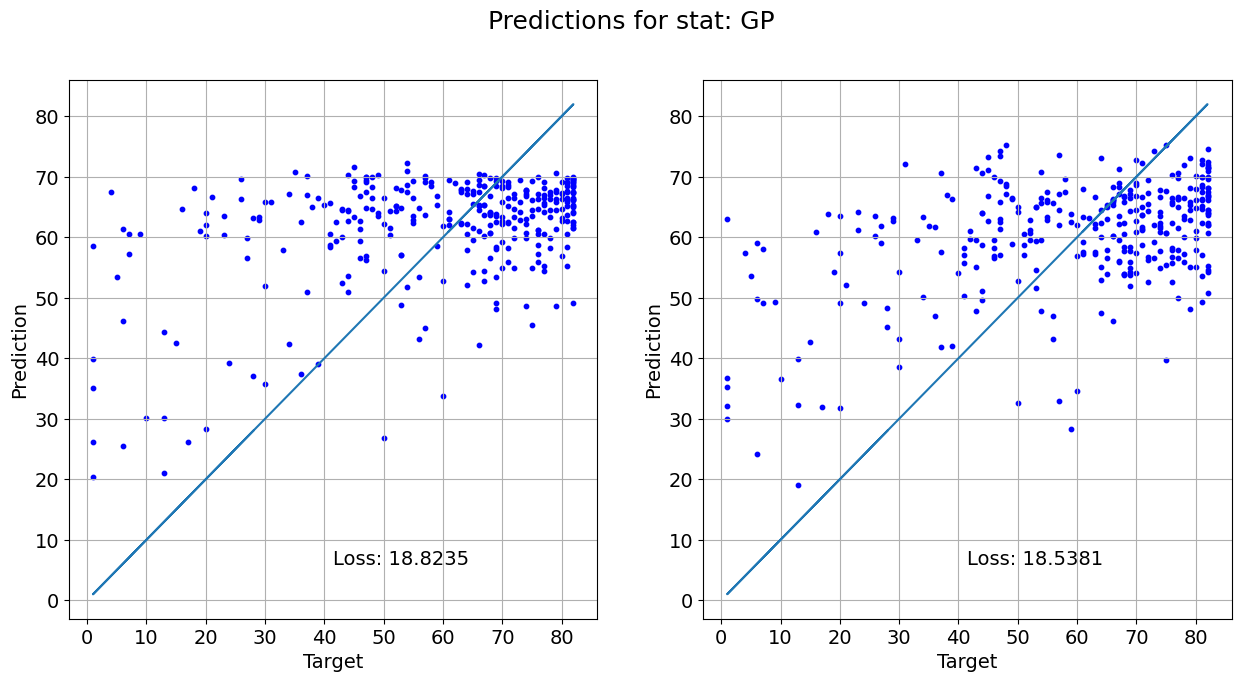

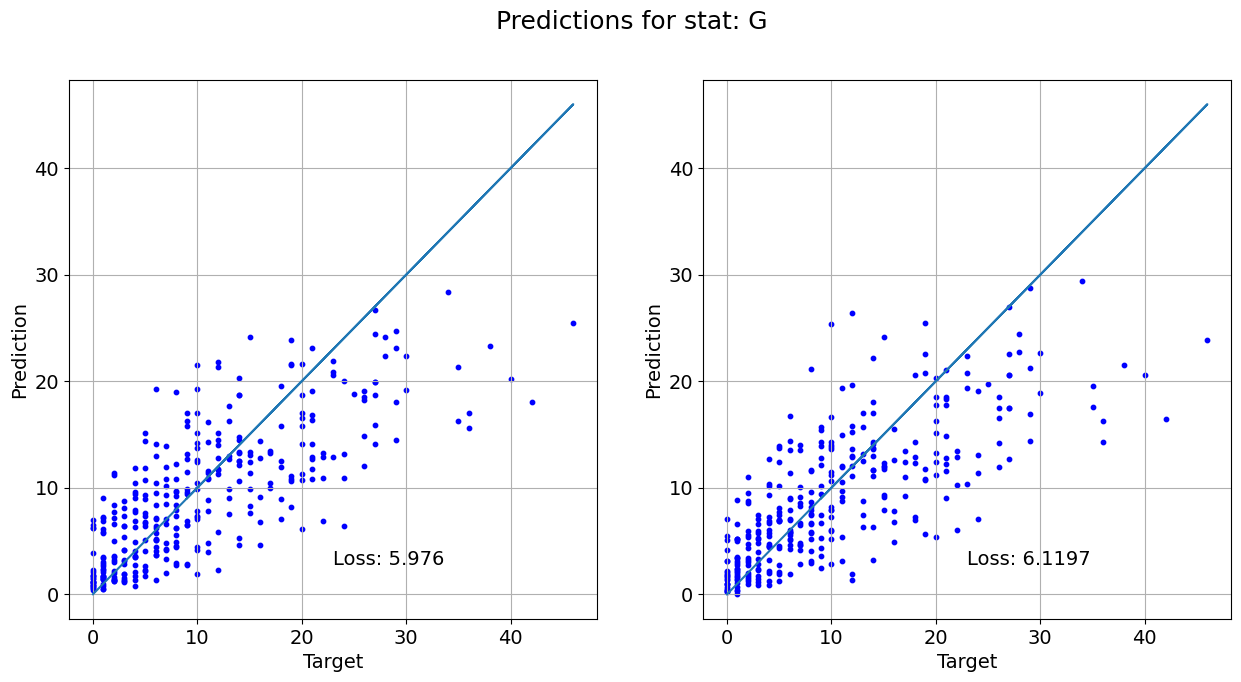

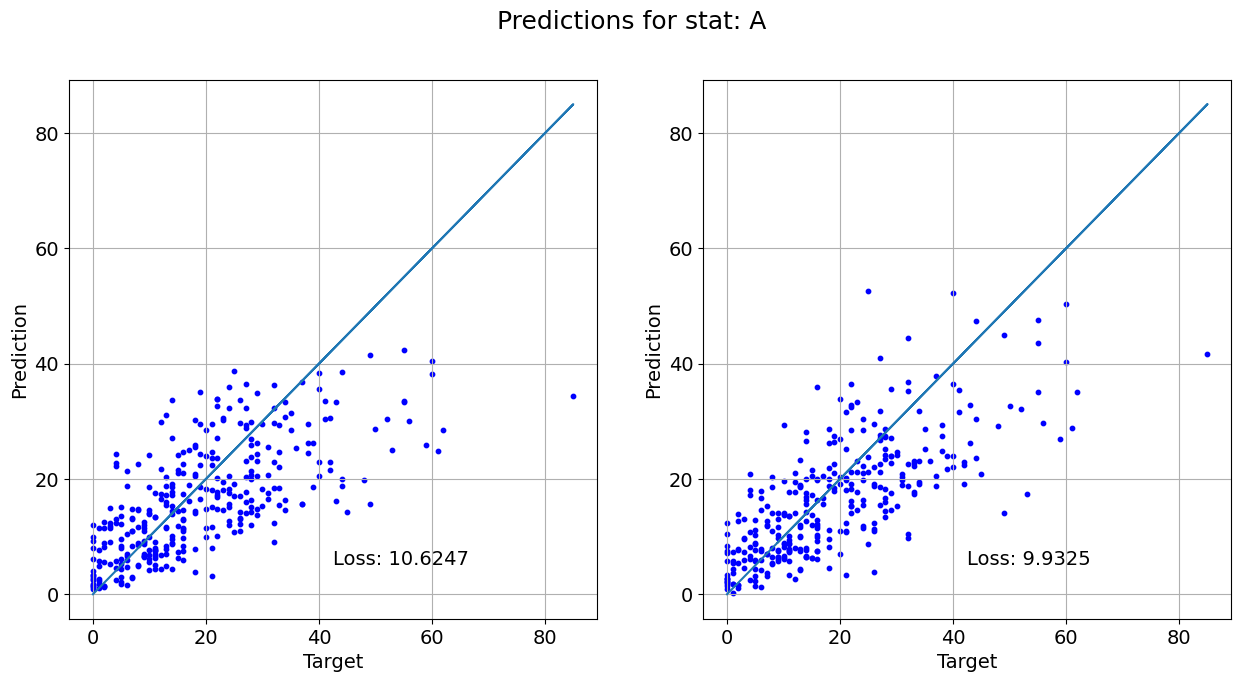

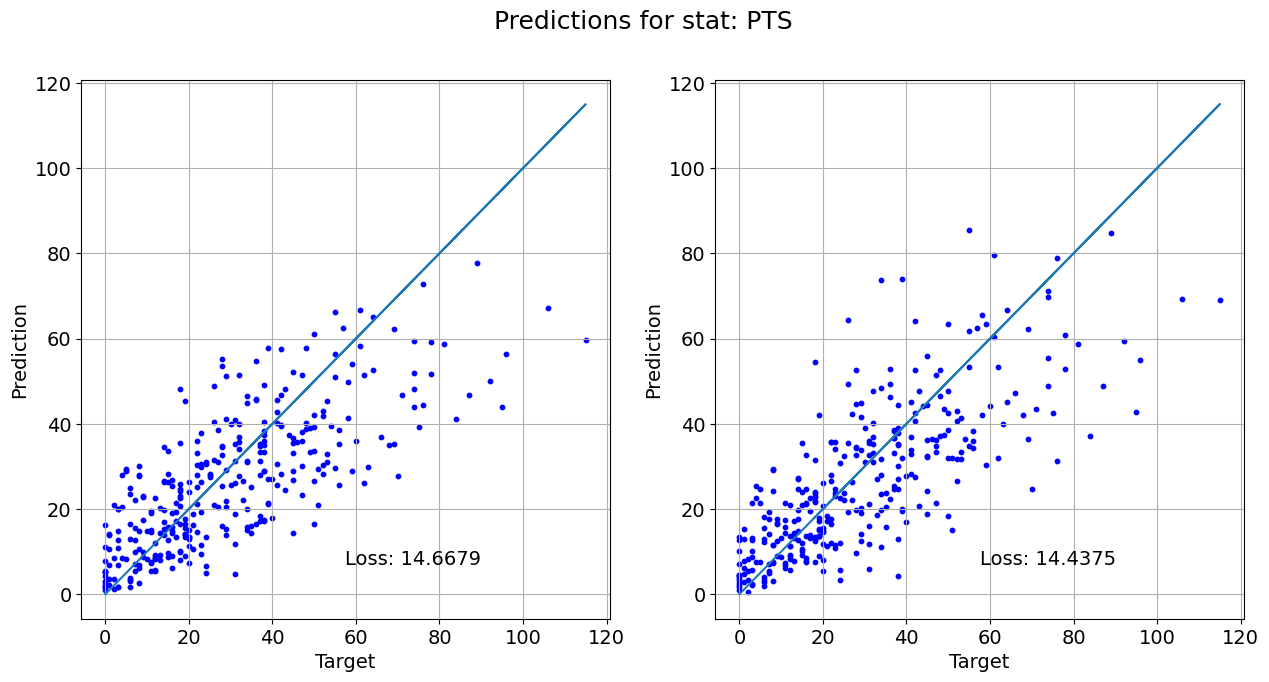

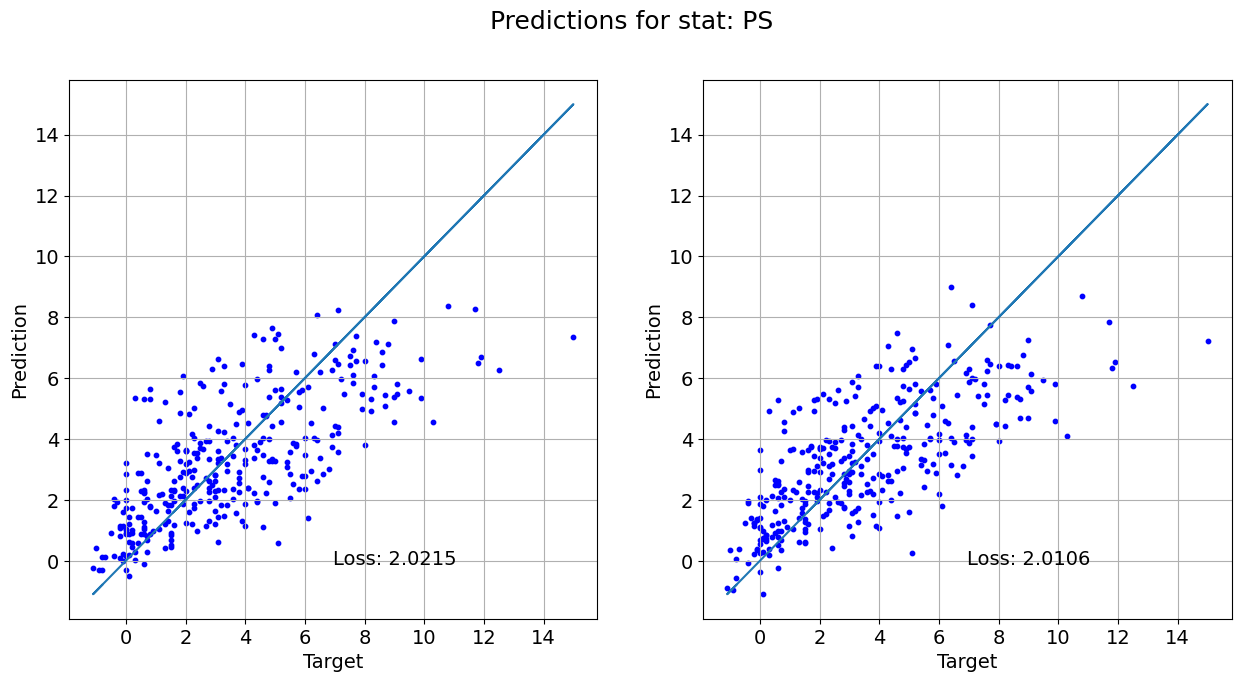

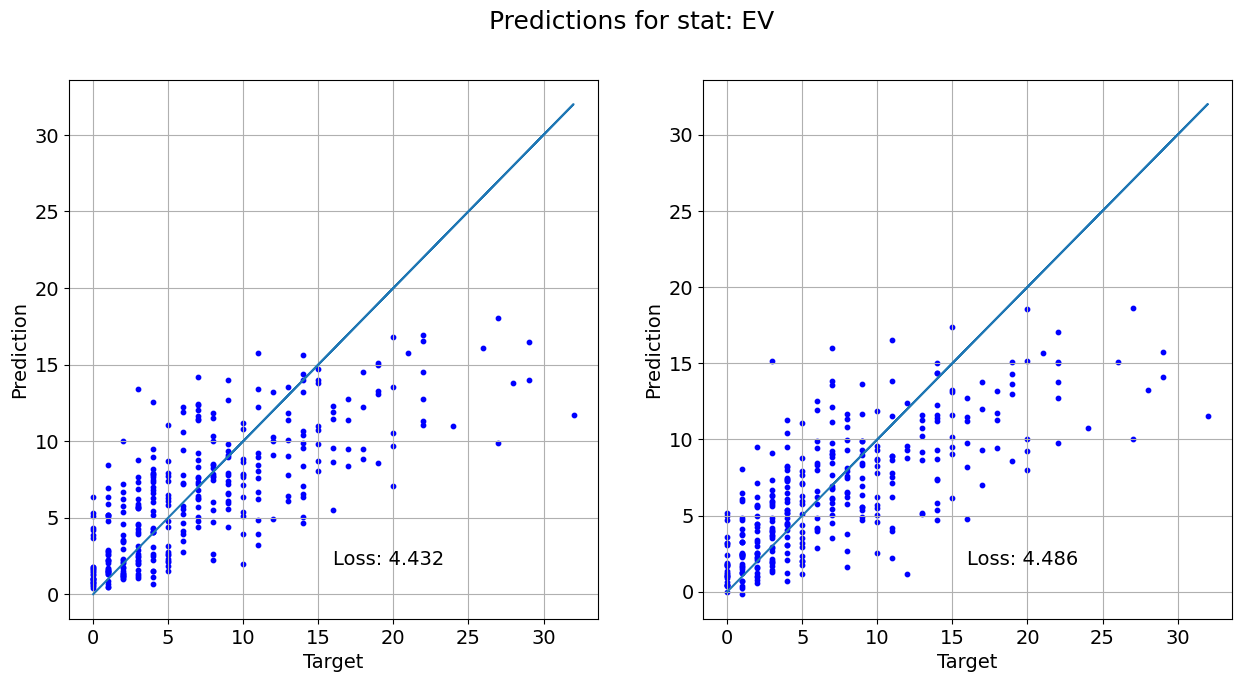

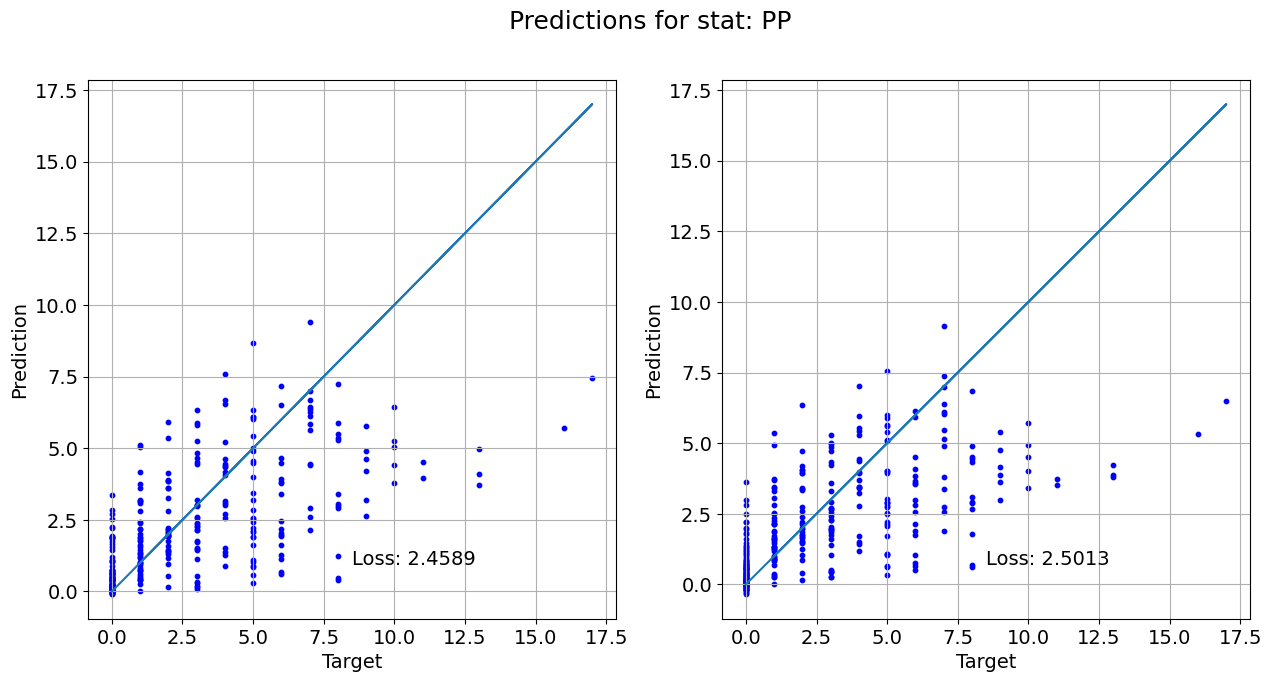

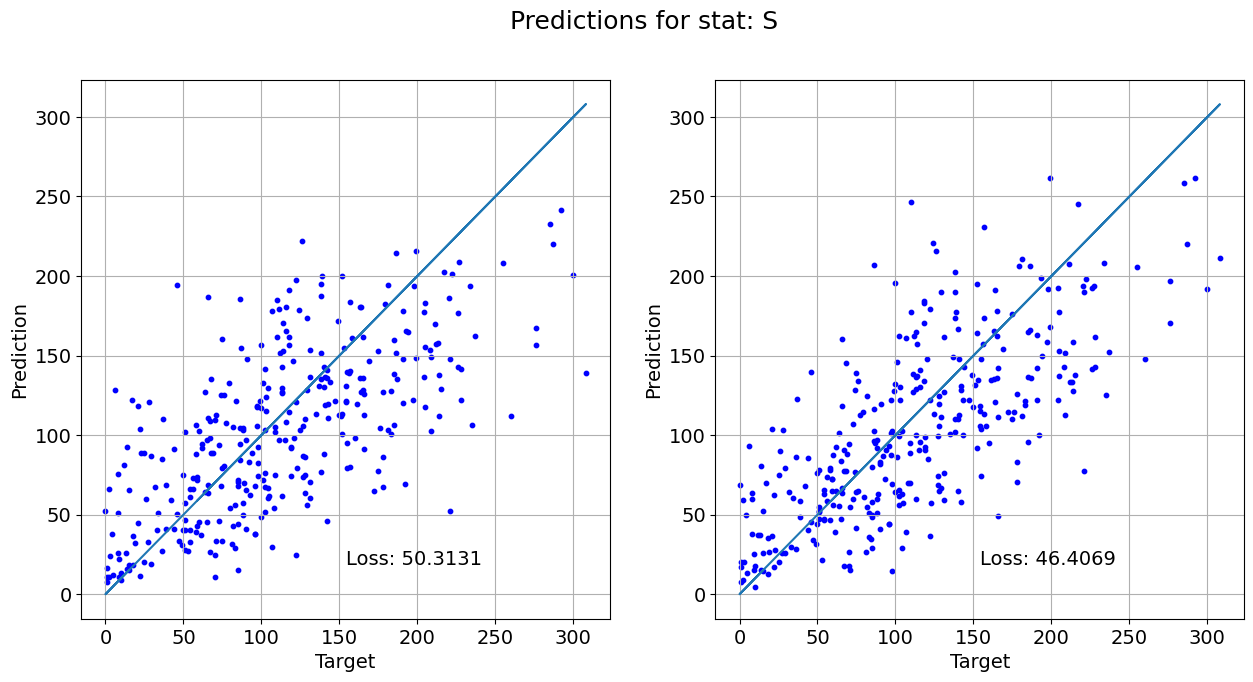

In [122]:
plot_correlation(preds_n_targets, criterion, stat_names=dataset.col_names)

In [128]:
series = []
for step, (x,y) in enumerate(dataset_train):
    plus_minus = torch.cat((x,y.unsqueeze(0)), dim=0)
    series.append(plus_minus[:,5])

avgs = torch.stack(series).mean()

diff = [series[i] - avgs for i in range(len(series))]

print(torch.stack(diff).mean(dim=0))

    

tensor([ 0.0186,  0.0169, -0.0004, -0.0351])
